**<font size=5>
淘宝用户消费行为分析
</font>**

1. 流量指标分析
2. 用户行为分析
3. 漏斗流失分析
4. 用户价值RFM分析

# 数据分析及可视化

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import warnings

plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False

# 有时候运行代码时会有很多warning输出，像提醒新版本之类的，如果不想这些乱糟糟的输出，可以使用如下代码
warnings.filterwarnings('ignore')

taobao_consume.csv文件

2014.11.24到2014.12.07之间，淘宝App移动端某页面两个自然周内的用户行为数据。

## 数据读入

In [2]:
data = pd.read_csv('taobao_consume.csv')
# 查看数据前五行
data.head()

,用户身份,商品id,用户行为类型,地理位置,品类id,行为发生时间
0,117903708,163031814,1,NaN,7590,2014-11-24 00
1,21973088,357709239,1,NaN,7957,2014-11-24 00
2,21973088,139760740,1,NaN,7957,2014-11-24 00
3,21973088,388438649,2,NaN,7957,2014-11-24 00
4,21973088,111066652,1,NaN,7957,2014-11-24 00


数据共包含458612条记录，每条记录有6个字段：

- 用户身份
- 商品id
- 用户行为类型(包括点击、收藏、加入购物车、支付四种行为，分别用数字1、2、3、4表示)
- 地理位置
- 品类id(商品所属的分类)
- 用户行为发生的时间

In [3]:
# 查看数据统计信息
data.describe()

,用户身份,商品id,用户行为类型,品类id
count,4.586120e+05,4.586120e+05,458612.000000,458612.000000
mean,7.165004e+07,2.020083e+08,1.104448,6856.238278
std,4.130555e+07,1.167418e+08,0.452881,3811.467551
min,4.913000e+03,1.040100e+04,1.000000,8.000000
25%,3.538948e+07,1.010827e+08,1.000000,3760.000000
50%,7.302413e+07,2.014393e+08,1.000000,6209.000000
75%,1.073774e+08,3.030931e+08,1.000000,10314.000000
max,1.424559e+08,4.045617e+08,4.000000,14080.000000


## 数据预处理

查看数据前五行的时候，发现第四列有不少空值，我们来计算一下各个字段的缺失率。

In [4]:
# 计算缺失率
data.apply(lambda x: sum(x.isnull())/len(x))

用户身份      0.000000
商品id      0.000000
用户行为类型    0.000000
地理位置      0.726342
品类id      0.000000
行为发生时间    0.000000
dtype: float64

地理位置数据缺失率为72.6%，缺失率比较高，所以我们把这列删除。

In [5]:
# 删除地理位置列
data.drop(['地理位置'], axis = 1, inplace = True)

数据中下单时间记录的是下单的日期和小时，后续我们想要分析一周中哪天是大家的“剁手”高峰期，或者在一天内几点是用户下单热门时段。因此我们把下单时间这一列进行拆分，将它记为两列数据。

In [6]:
# 处理日期数据为 日 小时
data['日期'] = data['行为发生时间'].str[0:-3]
data['小时'] = data['行为发生时间'].str[-2:]
# 将time、date列都变为标准日期格式，将hour列变为int格式
data['行为发生时间'] = pd.to_datetime(data['行为发生时间'])
data['日期'] = pd.to_datetime(data['日期'])
data['小时'] = data["小时"].astype(int)
data.dtypes

用户身份               int64
商品id               int64
用户行为类型             int64
品类id               int64
行为发生时间    datetime64[ns]
日期        datetime64[ns]
小时                 int32
dtype: object

In [7]:
# 按照time列升序排序
data.sort_values(by = "行为发生时间", ascending = True, inplace = True)
data.head()

,用户身份,商品id,用户行为类型,品类id,行为发生时间,日期,小时
0,117903708,163031814,1,7590,2014-11-24,2014-11-24,0
906,59511789,47879842,1,6513,2014-11-24,2014-11-24,0
905,59511789,105603945,2,1863,2014-11-24,2014-11-24,0
904,59511789,200144780,1,1863,2014-11-24,2014-11-24,0
903,59511789,389958035,1,5395,2014-11-24,2014-11-24,0


In [8]:
# 删除原索引
data.reset_index(drop=True,inplace=True)
data.head()

,用户身份,商品id,用户行为类型,品类id,行为发生时间,日期,小时
0,117903708,163031814,1,7590,2014-11-24,2014-11-24,0
1,59511789,47879842,1,6513,2014-11-24,2014-11-24,0
2,59511789,105603945,2,1863,2014-11-24,2014-11-24,0
3,59511789,200144780,1,1863,2014-11-24,2014-11-24,0
4,59511789,389958035,1,5395,2014-11-24,2014-11-24,0


In [9]:
# 对时间数据做一个概览
data['日期'].unique()

array(['2014-11-24T00:00:00.000000000', '2014-11-25T00:00:00.000000000',
       '2014-11-26T00:00:00.000000000', '2014-11-27T00:00:00.000000000',
       '2014-11-28T00:00:00.000000000', '2014-11-29T00:00:00.000000000',
       '2014-11-30T00:00:00.000000000', '2014-12-01T00:00:00.000000000',
       '2014-12-02T00:00:00.000000000', '2014-12-03T00:00:00.000000000',
       '2014-12-04T00:00:00.000000000', '2014-12-05T00:00:00.000000000',
       '2014-12-06T00:00:00.000000000', '2014-12-07T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [10]:
# 数据统计天数
data['日期'].nunique()

14

## 流量分析

对于互联网公司来讲，流量意味着话语权与生命力。而评估流量最常用的指标就是pv和uv。

- pv：page view的缩写，指的是页面总浏览量。每个用户每刷新一次网页，就会增加一次pv。
- uv：unique visitor的缩写，指的是独立访客。

### 总体pv与uv

In [11]:
# 两周的总pv
total_pv = data['用户身份'].count()
total_pv

458612

在每条访问记录中，避免重复计算相同用户访问，只求用户身份不同时的数据数量，就是我们想要的总uv。

In [12]:
# 两周的总uv
total_uv = data['用户身份'].nunique()
total_uv

8072

### 每日pv与uv

In [13]:
# 每日pv
pv_daily = data.groupby('日期')['用户身份'].count()
pv_daily

日期
2014-11-24    32292
2014-11-25    31510
2014-11-26    30792
2014-11-27    31338
2014-11-28    29817
2014-11-29    31685
2014-11-30    34824
2014-12-01    33658
2014-12-02    34625
2014-12-03    34896
2014-12-04    34286
2014-12-05    31370
2014-12-06    33119
2014-12-07    34400
Name: 用户身份, dtype: int64

In [14]:
# 每日uv
uv_daily = data.groupby('日期')['用户身份'].nunique()
uv_daily

日期
2014-11-24    4391
2014-11-25    4298
2014-11-26    4275
2014-11-27    4262
2014-11-28    4138
2014-11-29    4235
2014-11-30    4385
2014-12-01    4421
2014-12-02    4497
2014-12-03    4558
2014-12-04    4458
2014-12-05    4295
2014-12-06    4373
2014-12-07    4437
Name: 用户身份, dtype: int64

In [15]:
# 连接两个表
pv_uv_daily = pd.concat([pv_daily, uv_daily], axis = 1)
pv_uv_daily.columns = ['pv', 'uv']
pv_uv_daily

,pv,uv
日期,,
2014-11-24,32292,4391
2014-11-25,31510,4298
2014-11-26,30792,4275
2014-11-27,31338,4262
2014-11-28,29817,4138
2014-11-29,31685,4235
2014-11-30,34824,4385
2014-12-01,33658,4421
2014-12-02,34625,4497


我们分别为pv和uv数据绘制折线图，让它们在同一子图中显示。

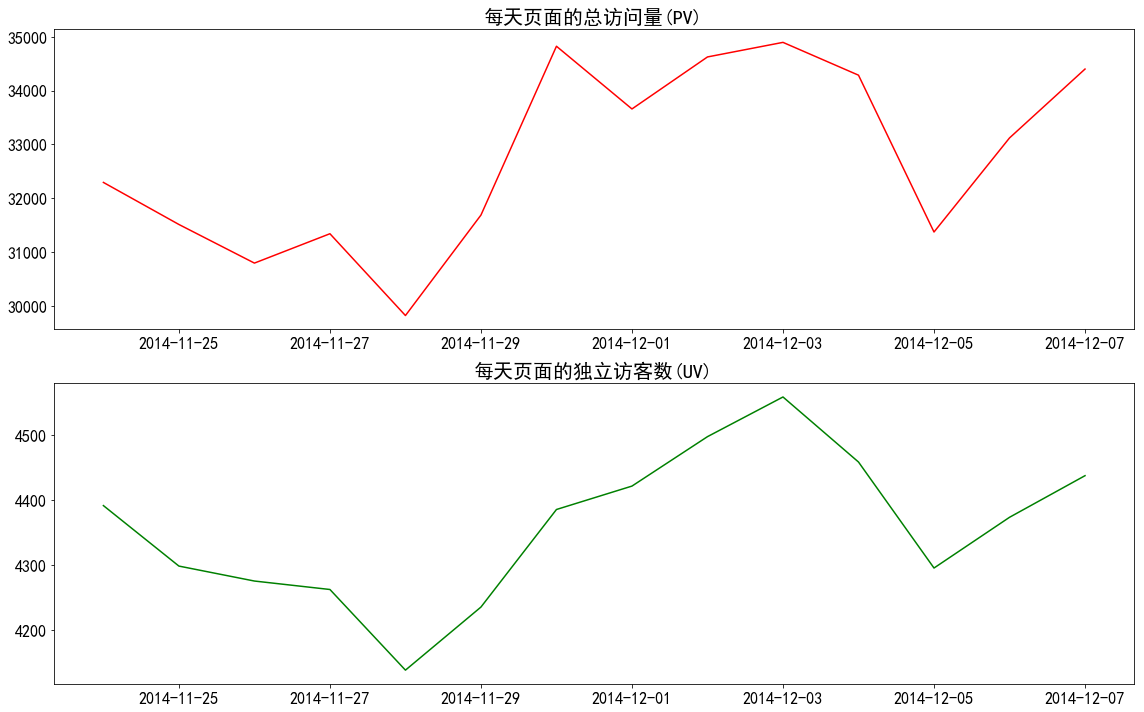

In [16]:
# 绘图
plt.figure(figsize = (16, 10))
plt.subplot(211)
plt.plot(pv_daily, c = "r")
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title("每天页面的总访问量(PV)", fontsize = 20)

plt.subplot(212)
plt.plot(uv_daily, c = "g")
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title("每天页面的独立访客数(UV)", fontsize = 20)
# plt.suptitle("每天PV和UV的变化趋势")
plt.tight_layout()
# plt.savefig("每天PV和UV的变化趋势", dpi = 300)
plt.show()

从图中可以看到，pv和uv数据呈现高度的正相关。pv和uv一周中的最低值都出现在周五，推测原因可能是用户周五白天上班，晚上结束一周的工作，聚会活动比较多。12月1日开始，pv和uv整体较上周都有所上升，追究原因我们发现12月1日开始，淘宝平台开启了双12预热活动，商家开始推出优惠信息，带来了pv和uv的整体上涨。

### 每小时pv与uv

In [17]:
# 每小时pv
pv_hour = data.groupby('小时')['用户身份'].count()
pv_hour

小时
0     19038
1     10089
2      5630
3      3876
4      3127
5      3457
6      5740
7     10339
8     14679
9     17978
10    20779
11    20004
12    19789
13    22509
14    22010
15    22689
16    21545
17    19150
18    20507
19    27010
20    34225
21    41123
22    41059
23    32260
Name: 用户身份, dtype: int64

In [18]:
# 每小时uv
uv_hour = data.groupby('小时')['用户身份'].nunique()
uv_hour

小时
0     2677
1     1517
2      937
3      657
4      574
5      658
6     1261
7     2228
8     3058
9     3558
10    3874
11    3888
12    4002
13    4087
14    4010
15    4012
16    3975
17    3816
18    3876
19    4381
20    4779
21    5010
22    4829
23    3927
Name: 用户身份, dtype: int64

In [19]:
# 连接两个表
pv_uv_hour = pd.concat([pv_hour, uv_hour], axis = 1)
pv_uv_hour.columns = ['pv_hour', 'uv_hour']
pv_uv_hour

,pv_hour,uv_hour
小时,,
0,19038,2677
1,10089,1517
2,5630,937
3,3876,657
4,3127,574
5,3457,658
6,5740,1261
7,10339,2228
8,14679,3058


我们再来画个折线图，把两个数据放在同一张图中对比观察，从图像中分析获取信息。

<Figure size 432x288 with 0 Axes>

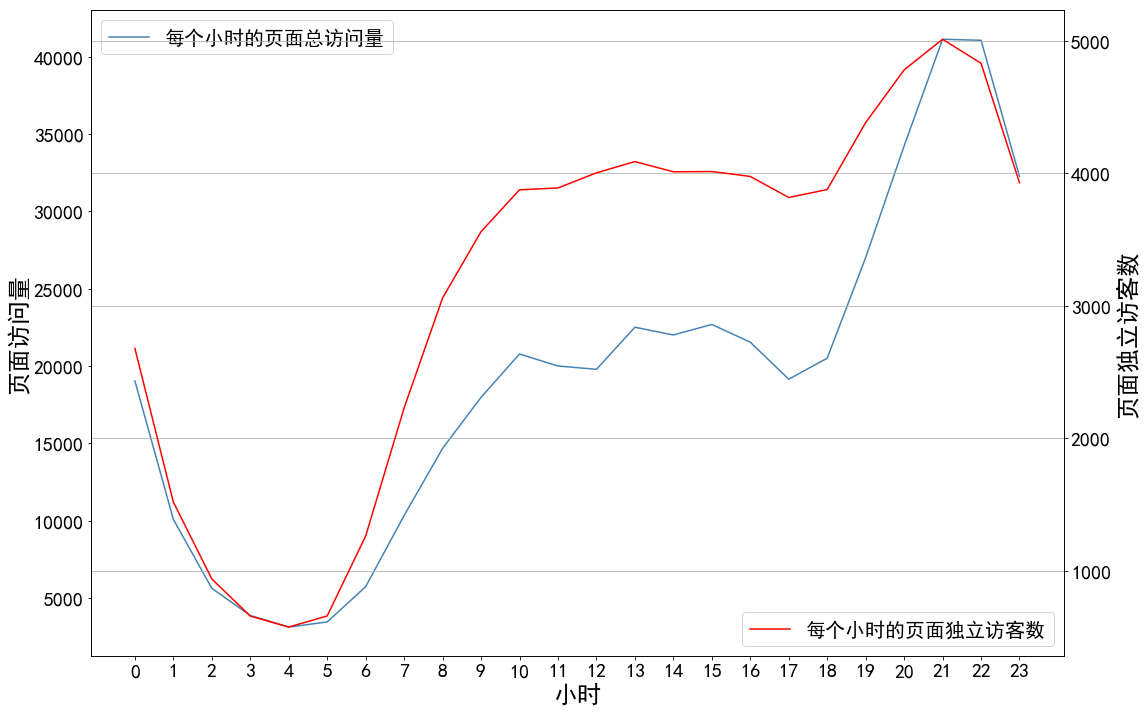

In [20]:
plt.figure()

ax = pv_uv_hour.plot(color = ['steelblue', 'red'], secondary_y = ['uv_hour'], figsize = (16,10), fontsize = 20)
ax.set_ylabel("页面访问量", fontsize = 24)
ax.right_ax.set_ylabel("页面独立访客数", fontsize = 24)
plt.xticks(range(0, 24), pv_uv_hour.index)
ax.set_xlabel("小时", fontsize = 24)

first_legend = ax.legend(['每个小时的页面总访问量'], loc = 'upper left', fontsize = 20)
second_legend = plt.legend(['每个小时的页面独立访客数'], loc = 'lower right', fontsize = 20)

plt.grid(True)

plt.tight_layout()
# plt.savefig("每个小时PV和UV的变化趋势", dpi = 300)
plt.show()

从图中可以看出，晚上22：00-凌晨5：00，页面的访问用户数量和访问量逐渐降低，该时间段很多人都处在休息之中。而从早上6：00-10：00用户数量逐渐呈现上升趋势，10：00-18：00有一个比较平稳的状态，这个时间段是正常的上班时间。但是18：00以后，一直到晚上22：00，用户剧烈激增，一直达到一天中访问用户数的最大值。

参考这份数据结果，业务相关的同事就可以针对用户的活跃时间段，例如18：00-22:00，采取一些促销活动。

## 用户行为分析

在逛淘宝时的浏览动作例如：点击、加入购物车、购买等行为都会被记录，这些数据我们经过分析也能得出关键结论，或许可以帮助运营产品的同事发现一些有用信息，提出合理建议。

原数据中记录了用户行为类型字段：用户行为类型，包括点击、收藏、加入购物车、支付四种行为，分别用数字1、2、3、4表示。

### 总计点击、收藏、添加购物车、支付用户的情况

In [21]:
type_1 = data[data['用户行为类型']==1]["用户身份"].count()
type_2 = data[data['用户行为类型']==2]["用户身份"].count()
type_3 = data[data['用户行为类型']==3]["用户身份"].count()
type_4 = data[data['用户行为类型']==4]["用户身份"].count()
print("点击用户：", type_1)
print("收藏用户：", type_2)
print("添加购物车用户：", type_3)
print("支付用户：", type_4)

点击用户： 432059
收藏用户： 9439
添加购物车用户： 12880
支付用户： 4234


从结果中可以看到，完成了页面点击$\rightarrow$收藏$\rightarrow$加入购物车$\rightarrow$支付的用户数量，呈现逐渐下降的趋势。

### 每日点击、收藏、添加购物车、支付用户的情况

我们创建一个透视表比较一下日期维度下的用户行为数据，然后再将数据绘制在图像中。

In [22]:
pv_date_type = pd.pivot_table(data,index = '日期', columns = '用户行为类型', values = '用户身份', aggfunc = np.size)
pv_date_type.columns = ["点击", "收藏", "加入购物车", "支付"]
pv_date_type.head()

,点击,收藏,加入购物车,支付
日期,,,,
2014-11-24,30510,629,858,295
2014-11-25,29615,701,886,308
2014-11-26,29060,642,812,278
2014-11-27,29503,650,861,324
2014-11-28,28119,578,819,301


产生点击行为的用户数量级较大，与其它数据放在同一个坐标系中不方便我们发现数据的波动幅度，所以这里我们只绘制了收藏、加入购物车、支付的用户数据。

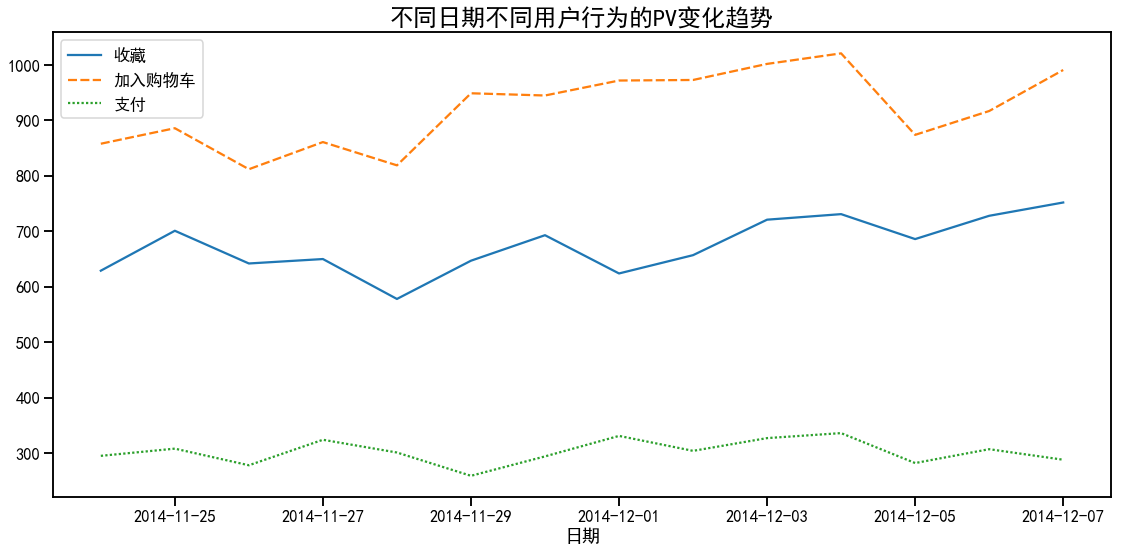

In [23]:
plt.figure(figsize = (16, 8))
sns.set_context("talk")
sns.lineplot(data = pv_date_type[['收藏', '加入购物车', '支付']])

plt.title("不同日期不同用户行为的PV变化趋势", fontsize = 24)
plt.tight_layout()
# plt.savefig("不同日期不同用户行为的PV变化趋势", dpi = 300)
plt.show()

可以看到，三种行为的数据在每周不同天基本同幅波动，与前面pv、uv的波动规律相似。依然是周五数据整体偏低，看来大家周五下班是真的需要出门放风，释放自我。

### 每小时点击、收藏、添加购物车、支付用户的情况

In [24]:
pv_hour_type = pd.pivot_table(data,index = '小时', columns = '用户行为类型', values = '用户身份', aggfunc = np.size)
pv_hour_type.columns = ["点击", "收藏", "加入购物车", "支付"]
pv_hour_type

,点击,收藏,加入购物车,支付
小时,,,,
0,17977,482,454,125
1,9562,241,232,54
2,5361,114,142,13
3,3671,77,109,19
4,2922,94,99,12
5,3258,100,83,16
6,5448,136,134,22
7,9790,224,274,51
8,13893,306,353,127


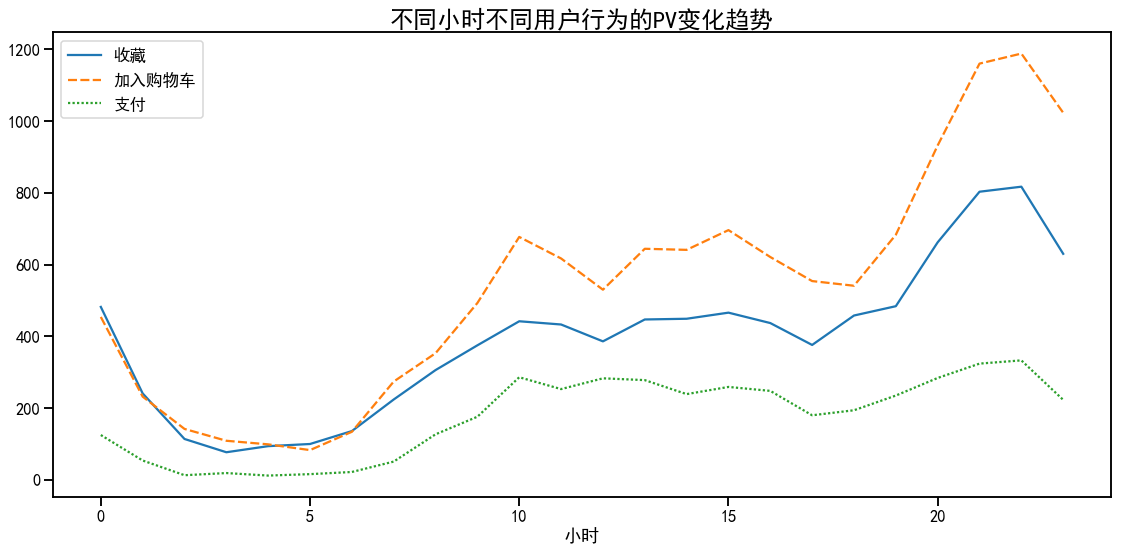

In [25]:
plt.figure(figsize=(16, 8))
sns.lineplot(data = pv_hour_type[['收藏', '加入购物车', '支付']])

# pv_hour_type["点击"].plot(c="pink",linewidth=5,label="点击",secondary_y=True)
# plt.legend(loc="best")

plt.title("不同小时不同用户行为的PV变化趋势", fontsize = 24)
plt.tight_layout()
# plt.savefig("不同小时不同用户行为的PV变化趋势", dpi = 300)
plt.show()

可以看出：凌晨5点，用户的收藏、加购、支付行为都达到了最低值，之后逐步上升，10点之后逐渐平稳，傍晚6点之后又出现了增长的趋势，22时达到了巅峰。这也与我们之前日维度下统计的pv和uv值基本同步。

用户下单支付是整个流程中要得到的最终结果，下面我们着重研究一下付费情况。

### 人均消费次数分析

In [26]:
total_consumer = data[data['用户行为类型'] == 4].groupby(["日期", "用户身份"])["用户行为类型"].count()\
                .reset_index().rename(columns = {"用户行为类型": "消费次数"})
total_consumer.head()

,日期,用户身份,消费次数
0,2014-11-24,414388,1
1,2014-11-24,1926899,1
2,2014-11-24,2319819,1
3,2014-11-24,2695854,1
4,2014-11-24,3233000,1


In [27]:
total_consume = total_consumer.groupby("日期").sum()["消费次数"]/\
                total_consumer.groupby("日期").count()["消费次数"]
total_consume

日期
2014-11-24    1.194332
2014-11-25    1.232000
2014-11-26    1.275229
2014-11-27    1.213483
2014-11-28    1.243802
2014-11-29    1.204651
2014-11-30    1.152941
2014-12-01    1.216912
2014-12-02    1.169231
2014-12-03    1.252874
2014-12-04    1.195730
2014-12-05    1.194915
2014-12-06    1.237903
2014-12-07    1.195021
Name: 消费次数, dtype: float64

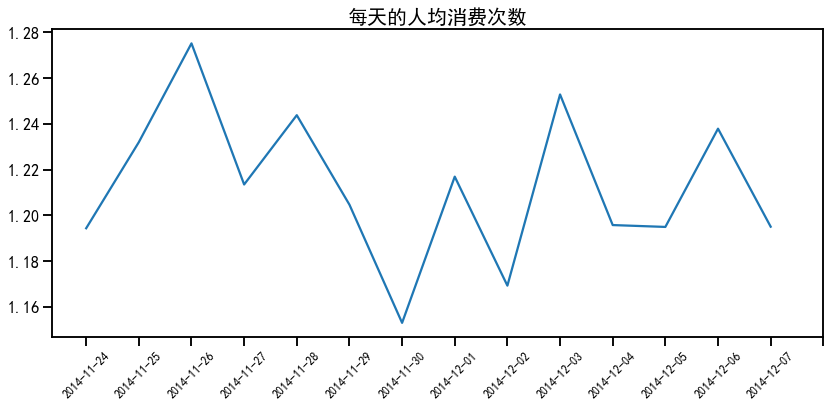

In [28]:
x = len(total_consume.index.astype(str))
y = total_consume.index.astype(str)

plt.figure(figsize = (12, 6))
plt.plot(total_consume.values)
plt.xticks(range(0, 15),[y[i] for i in range(0, x, 1)], rotation = 45, fontsize = 12)
plt.yticks(fontsize = 16)
plt.title("每天的人均消费次数", fontsize = 20)

plt.tight_layout()
# plt.savefig("每天的人均消费次数", dpi = 300)
plt.show()

可以看到，这两周中付费用户每天的人均消费次数大约在1.2左右波动，付费行为整体比较稳定。

11月30日人均消费次数最低，可能是因为12.1开启双十二预热活动，与其30号购买，不如等降价活动开始再下单。

### 活跃用户人均消费次数

如果活跃用户数量很多，但他们的人均消费次数数值偏低，运营和产品的同事可能就需要调整活动方案或者策略，想办法提高人均消费次数。

In [29]:
data["operation"] = 1
active_consumer = data.groupby(["日期", "用户身份", '用户行为类型'])["operation"].count().\
                reset_index().rename(columns = {"operation": "总计"})
active_consumer.head(10)

,日期,用户身份,用户行为类型,总计
0,2014-11-24,4913,1,4
1,2014-11-24,7591,1,4
2,2014-11-24,12645,1,1
3,2014-11-24,88930,1,11
4,2014-11-24,113251,1,2
5,2014-11-24,113960,1,10
6,2014-11-24,120873,1,5
7,2014-11-24,120873,2,2
8,2014-11-24,151617,1,14
9,2014-11-24,156608,1,4


In [30]:
active_consume = active_consumer.groupby("日期").apply(lambda x: x[x["用户行为类型"]==4]["总计"].sum()/\
                                                     x["用户身份"].nunique())
active_consume

日期
2014-11-24    0.067183
2014-11-25    0.071661
2014-11-26    0.065029
2014-11-27    0.076021
2014-11-28    0.072740
2014-11-29    0.061157
2014-11-30    0.067047
2014-12-01    0.074870
2014-12-02    0.067601
2014-12-03    0.071742
2014-12-04    0.075370
2014-12-05    0.065658
2014-12-06    0.070204
2014-12-07    0.064909
dtype: float64

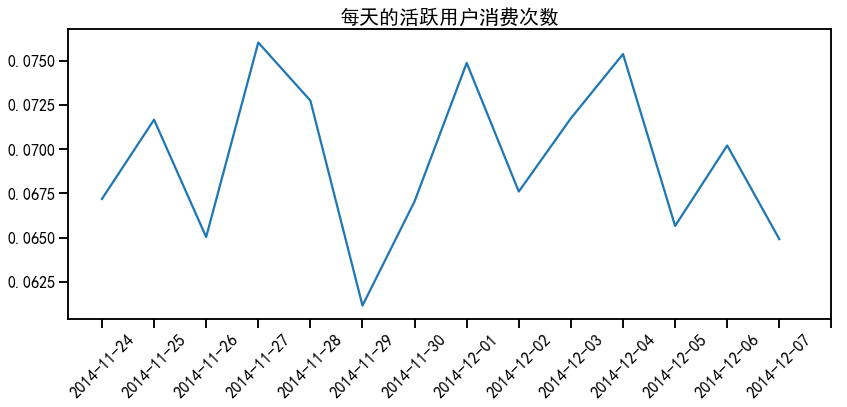

In [31]:
x = len(active_consume.index.astype(str))
y = active_consume.index.astype(str)

plt.figure(figsize = (12, 6))
plt.plot(active_consume.values)
plt.xticks(range(0, 15), [y[i] for i in range(0, x)], rotation = 45)
plt.yticks(fontsize = 16)
plt.title("每天的活跃用户消费次数", fontsize = 20)

plt.tight_layout()
# plt.savefig("每天的活跃用户消费次数", dpi = 300)
plt.show()

可以看到，活跃用户的人均消费次数在0.07左右波动，业务部门的同事可以针对这个指标继续优化用户的付费转化。

### 付费率PUR

付费率（PUR，Pay User Rate）是指统计周期内，付费账号数占活跃账号数的比例。

这里我们使用 $\frac{消费人数}{活跃用户人数}$ 计算付费率。

In [32]:
pay_user_rate = active_consumer.groupby("日期").apply(lambda x: x[x["用户行为类型"]==4]["总计"].count()/\
                                                    x["用户身份"].nunique())
pay_user_rate

日期
2014-11-24    0.056251
2014-11-25    0.058167
2014-11-26    0.050994
2014-11-27    0.062647
2014-11-28    0.058482
2014-11-29    0.050767
2014-11-30    0.058153
2014-12-01    0.061525
2014-12-02    0.057816
2014-12-03    0.057262
2014-12-04    0.063033
2014-12-05    0.054948
2014-12-06    0.056712
2014-12-07    0.054316
dtype: float64

In [33]:
active_consumer.groupby("日期").apply(lambda x: x[x["用户行为类型"]==4]['总计'].count()/x["用户身份"].nunique())

日期
2014-11-24    0.056251
2014-11-25    0.058167
2014-11-26    0.050994
2014-11-27    0.062647
2014-11-28    0.058482
2014-11-29    0.050767
2014-11-30    0.058153
2014-12-01    0.061525
2014-12-02    0.057816
2014-12-03    0.057262
2014-12-04    0.063033
2014-12-05    0.054948
2014-12-06    0.056712
2014-12-07    0.054316
dtype: float64

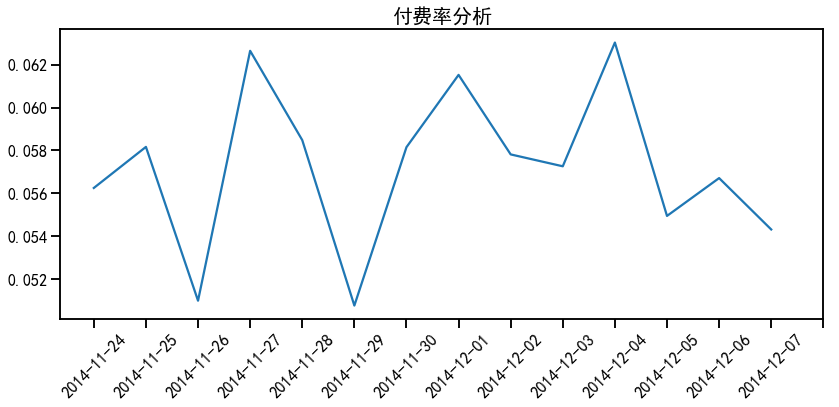

In [34]:
x = len(pay_user_rate.index.astype(str))
y = pay_user_rate.index.astype(str)

plt.figure(figsize = (12, 6))
plt.plot(pay_user_rate.values)
plt.xticks(range(0, 15), [y[i] for i in range(0, x, 1)], rotation = 45)
plt.yticks(fontsize = 16)
plt.title("付费率分析", fontsize = 20)

plt.tight_layout()
# plt.savefig("付费率分析", dpi = 300)
plt.show()

可以看到，付费用户在活跃用户中的占比大约为5%-6%，12月1日之后付费率整体有了一个正向的上升。

看来双十二的预售活动提高了大家的消费热情，更多用户准备开心的买买买了。后续也可以通过持续检测这项数据来对评判活动的效果和影响。

通过对用户行为的分析，我们搞清楚了下单“剁手”规律，那么没有被转化的用户都是在哪一步流失的呢？下面就根据数据来追踪一下。

## 漏斗分析

漏斗分析是一个常用的数据分析模型。在漏斗分析中，每个步骤只会有部分用户进入到下一步骤中。从页面点击到最终支付，中间每一步都会流失部分用户，通过漏斗分析能让我们了解当前的转化状态，为增长提供基础。

我们在原数据中记录了用户完成页面 点击$\rightarrow$收藏$\rightarrow$加入购物车$\rightarrow$支付 四个步骤的行为数据，这四种行为之间存在转化的过程。我们先统计每种行为的总人数。

In [35]:
df_count = data.groupby("用户行为类型").size().reset_index().rename(columns = {"用户行为类型": "环节", 0: "人数"})
df_count

,环节,人数
0,1,432059
1,2,9439
2,3,12880
3,4,4234


In [36]:
type_dict = {1: "点击", 2: "收藏", 3: "加入购物车", 4: "支付"}
df_count["环节"] = df_count["环节"].map(type_dict)
df_count

,环节,人数
0,点击,432059
1,收藏,9439
2,加入购物车,12880
3,支付,4234


在实际网购过程中，收藏或将物品加入购物车，都表明用户有一定程度购买意向，只差最后一步就能完成付费下单了。所以我们把收藏和加入购物车这两种行为相加合并，作为一个环节统计人数。

In [37]:
b1 = df_count.iloc[0]["人数"]
b2 = df_count.iloc[1]["人数"]
b3 = df_count.iloc[2]["人数"]
b4 = df_count.iloc[3]["人数"]
funnel = pd.DataFrame({"环节":["点击", "收藏或加入购物车", "支付"], "人数": [b1, b2 + b3, b4]})
funnel

,环节,人数
0,点击,432059
1,收藏或加入购物车,22319
2,支付,4234


接下来可以计算每步的转化率了。这里的总体转化率计算的是从一开始的“点击页面”到对应步骤的转化情况；单一转化率指的是从上一步到对应步骤的转化情况。

In [38]:
# 计算每个步骤的转化率
funnel["总体转化率"] = [i / funnel["人数"][0] for i in funnel["人数"]]
funnel["单一转化率"] = np.array([1.0, 2.0, 3.0])
for i in range(0, len(funnel["人数"])):
    if i == 0:
        funnel["单一转化率"][i] = 1.0
    else:
        funnel["单一转化率"][i] = funnel["人数"][i] / funnel["人数"][i - 1]

funnel

,环节,人数,总体转化率,单一转化率
0,点击,432059,1.000000,1.000000
1,收藏或加入购物车,22319,0.051657,0.051657
2,支付,4234,0.009800,0.189704


In [39]:
import plotly.express as px
import plotly.graph_objs as go

trace = go.Funnel(
    y = ["点击", "收藏或加入购物车", "购买"],
    x = [funnel["人数"][0], funnel["人数"][1], funnel["人数"][2]],
    # textfont = {'size': 20},
    textinfo = "value+percent initial",
    marker = dict(color=["deepskyblue", "lightsalmon", "tan"]),
    connector = {"line": {"color": "royalblue", "dash": "solid", "width": 3}})

conversion_data = [trace]

fig = go.Figure(conversion_data)

fig.show()

从上面的漏斗图可以看出，从浏览到具有购买意向(收藏和加入购物车)，只有5%的转化率，而到了真正购买的转化率只有1%。

再看“单一转化率”，即每一步的转化率，从具有购买意向到真正购买的转化率达到了20%。说明从浏览到进行收藏和加入购物车的阶段，是指标提升的重要环节。负责业务的同事就可以在这个步骤多加研究，想方设法提高这一阶段的数据。

## 用户价值分析

经过上面的分析我们可以看到，在每一步都会有大量的用户流失，那么该如何挽回？怎么从海量的用户中筛选出真正有价值的用户，让我们距离业绩小目标更近一步呢？

RFM 模型是数据分析中衡量客户价值和客户创利能力的一个重要模型。我们会搜集用户三个方面的数据来综合评定用户的价值等级：

- R（Recency）：最近一次购买的时间有多远

- F（Frequency）：最近一段时间内的消费频率

- M（Monetary）：最近一段时间内的消费金额

最近一次消费时间越近的顾客是越有可能产生二次消费的群体，购买次数越多的用户是对我们产品越满意的客户，表示用户的忠诚度越高，消费金额越高的用户价值越大。通过分析一个用户的近期购买行为（R）、购买的总体频率（F）以及消费总金额（M）三项指标，就可以描述出用户的价值状况。

我们可以将每个用户的R、F、M与均值比较，每个指标得到两个结果，大于等于或者小于，然后进行排列组合，就可以将用户划分为8个等级：重要价值用户、重要保持用户、重要唤回用户、重要深耕用户、重要挽留用户、潜力用户、新用户、一般维持用户、流失用户。

原由于数据中不包含用户的消费金额，所以我们只考虑用户的购买时间和购买次数。首先计算出我们需要的数据：最近一次购买时间有多远和最近一段时间的消费频率。

In [40]:
from datetime import datetime

# 最近一次消费距离现在的天数
recent_buy = data[data["用户行为类型"] == 4].groupby("用户身份")["日期"].\
    apply(lambda x: datetime(2014, 12, 20) - x.sort_values().iloc[-1]).reset_index().\
    rename(columns = {"日期": "最近消费时间距现在"})
recent_buy["最近消费时间距现在"] = recent_buy["最近消费时间距现在"].apply(lambda x: x.days)
recent_buy.head()

,用户身份,最近消费时间距现在
0,7591,14
1,12645,17
2,79824,15
3,88930,24
4,100539,13


In [41]:
# 消费频率计算
buy_freq = data[data["用户行为类型"] == 4].groupby("用户身份")["日期"].count().reset_index().\
          rename(columns={"日期":"消费频率"})
buy_freq.head()

,用户身份,消费频率
0,7591,4
1,12645,2
2,79824,1
3,88930,1
4,100539,1


将这两列数据合并给用户打分，消费时间越近，消费金额越高，分数越高，也说明这个用户更有价值。

In [42]:
rfm = pd.merge(recent_buy, buy_freq, on = "用户身份")
rfm.head()

,用户身份,最近消费时间距现在,消费频率
0,7591,14,4
1,12645,17,2
2,79824,15,1
3,88930,24,1
4,100539,13,1


In [43]:
# 给不同类型打分
r_bins = [0, 5, 10, 15, 20, 50]
f_bins = [1, 30, 60, 90, 120, 900]
rfm["消费时间打分"] = pd.cut(rfm["最近消费时间距现在"], bins = r_bins, labels = [5, 4, 3, 2, 1], right = False)
rfm["消费频率打分"] = pd.cut(rfm["消费频率"], bins = f_bins, labels = [1, 2, 3, 4, 5], right = False)
for i in ["消费时间打分","消费频率打分"]:
    rfm[i] = rfm[i].astype(float)

rfm.describe()

,用户身份,最近消费时间距现在,消费频率,消费时间打分,消费频率打分
count,2.493000e+03,2493.000000,2493.000000,2493.000000,2493.000000
mean,7.117988e+07,18.645808,1.698355,1.779783,1.000401
std,4.139782e+07,3.954306,1.551828,0.737143,0.020028
min,7.591000e+03,13.000000,1.000000,1.000000,1.000000
25%,3.445365e+07,15.000000,1.000000,1.000000,1.000000
50%,7.265122e+07,18.000000,1.000000,2.000000,1.000000
75%,1.074138e+08,22.000000,2.000000,2.000000,1.000000
max,1.424302e+08,26.000000,40.000000,3.000000,2.000000


调用describe()函数我们得到消费时间和频率打分的平均值，然后把各分值与得到的均值做比较，高于均值标注“高”，低于它则标注“低”。综合消费时间和消费频率，最终得出综合值，以此判定用户的价值。

In [44]:
# 比较各分值与各自均值的大小
rfm["时间结果"] = np.where(rfm["消费时间打分"] > 1.779783, "高", "低")
rfm["频率结果"] = np.where(rfm["消费频率打分"] > 1.000401, "高", "低")
# 将r和f列的字符串合并起来
rfm["综合值"] = rfm["时间结果"].str[:] + rfm["频率结果"].str[:]

根据打分结果，给用户贴上对应标签，计算出每个类型用户的数量，业务负责的同事们就可以根据标签来区别用户。

In [45]:
# 自定义函数给用户贴标签
def trans_labels(x):
    if x == "高高":
        return "重要价值用户"
    elif x == "低高":
        return "重要唤回用户"
    elif x == "高低":
        return "重要深耕用户"
    else:
        return "重要挽回用户"

rfm["标签"] = rfm["综合值"].apply(trans_labels)

In [46]:
rfm.head()

,用户身份,最近消费时间距现在,消费频率,消费时间打分,消费频率打分,时间结果,频率结果,综合值,标签
0,7591,14,4,3.0,1.0,高,低,高低,重要深耕用户
1,12645,17,2,2.0,1.0,高,低,高低,重要深耕用户
2,79824,15,1,2.0,1.0,高,低,高低,重要深耕用户
3,88930,24,1,1.0,1.0,低,低,低低,重要挽回用户
4,100539,13,1,3.0,1.0,高,低,高低,重要深耕用户


In [47]:
# 计算出每个标签的用户数量
rfm["标签"].value_counts()

重要深耕用户    1480
重要挽回用户    1012
重要价值用户       1
Name: 标签, dtype: int64

可以看到，在这两周的用户群体中，有1480位是重要深耕用户，有1012位重要挽回用户，1位重要价值用户，负责业务的同事可以根据结果找到对应的用户，针对性地做一些运营手段。